In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [3]:
import pynapple as nap

In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [5]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_btsp_burst'
misc.get_or_create_subdir(figdir)
suppfigdir =misc.get_or_create_subdir(figdir,'supp')
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_btsp_burst
/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_btsp_burst/supp
/mnt/home/szheng/ceph/place_variability/data/paper


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [6]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

pf_params_all = prepped_data_agg['pf_params_all']
all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [8]:
trial_index_to_index_within_df_all=prepped_data_agg['trial_index_to_index_within_df_all']
index_within_to_trial_index_df_all=prepped_data_agg['index_within_to_trial_index_df_all'] 

In [9]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# test whether formation trial FR is higher than after

In [10]:
X_raw_all_norm = X_raw_all / X_raw_all.max(axis=1).values[:,None]

In [11]:
peri_sw_fr_all = {}
trial_win = 3
is_backward_all = {}
for sw in [1,-1]:
    all_sw_with_metrics_d_all_onoff=all_sw_with_metrics_d_all.query(f'switch==@sw')
    peri_sw_fr_all_onoff = {}
    for ind,row in all_sw_with_metrics_d_all_onoff.iterrows():
        ani,sess,ti,sw_ind=ind
        tt,uid,field_index,sw_tr,trial_ind = row['trialtype'],row['uid'],row['field_index'],row['switch_trial'],row['trial_index']
        sw_tr = int(sw_tr)
    #     fr_sel = X_raw_all_norm.loc[(ani,sess,ti,tt,uid,field_index),trial_index-2:trial_index+2]
    #     if len(fr_sel)==2*2+1:
    #         fr_sel.index = np.arange(-2,3)
    #         peri_sw_fr_all[(ani,sess,ti,tt,uid,field_index,sw_ind)] = fr_sel

        X_raw_onefield=X_raw_all_norm.loc[(ani,sess,ti,tt,uid,field_index)].dropna().values
    #     X_raw_onefield=X_raw_all_norm.loc[(ani,sess,ti,tt,uid,field_index)].values
        X_raw_onefield_padded=np.concatenate([[np.nan] * trial_win,X_raw_onefield,[np.nan] * trial_win])
        fr_sel = pd.Series(X_raw_onefield_padded[sw_tr:sw_tr+trial_win*2+1])
        peri_sw_fr_all_onoff[(ani,sess,ti,tt,uid,field_index,sw_ind)] = fr_sel
        
        
    peri_sw_fr_all_onoff = pd.concat(peri_sw_fr_all_onoff,axis=0).unstack() # ani,sess,ti,tt,uid,field_id,switch_ind
    peri_sw_fr_all[sw] = peri_sw_fr_all_onoff
peri_sw_fr_all = pd.concat(peri_sw_fr_all,axis=0)

cols_ind = np.arange(-trial_win,trial_win+1)
peri_sw_fr_all.columns = cols_ind

is_backward_all = pd.Series(is_backward_all)

    #     row

/tmp/ipykernel_1089601/107663690.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  is_backward_all = pd.Series(is_backward_all)


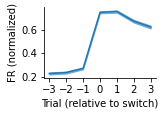

In [31]:
from matplotlib.ticker import MaxNLocator
fig,ax=plt.subplots(figsize=(2,1.3))
toplot=peri_sw_fr_all.loc[(1,slice(None),slice(None),0,slice(None)),:]
# diff=toplot[5]-toplot[4]
# print(scipy.stats.wilcoxon(diff.dropna()))
fig,ax=ph.mean_error_plot(toplot,fig=fig,ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.despine()
ax.set_ylabel('FR (normalized)')
ax.set_xlabel('Trial (relative to switch)')

figfn = 'peri_sw_on_fr_peak_vs_trial'
ph.save_given_name(fig,figfn,figdir=figdir)

In [19]:
def consecutive_wilcoxon_test(df):
    cols = df.columns
    res_all = {}
    for i in range(1,len(cols)):
        diff = df[cols[i]] - df[cols[i-1]]
        res=scipy.stats.wilcoxon(diff.dropna(axis=0))
        res_all[(cols[i-1],cols[i])] = res
    return res_all

In [34]:
df.shape

(1852, 7)

In [32]:
df = toplot
res_all = consecutive_wilcoxon_test(df)
res_all

{(-3, -2): WilcoxonResult(statistic=579676.0, pvalue=0.004513240526951757),
 (-2, -1): WilcoxonResult(statistic=570333.0, pvalue=1.1143215284362657e-20),
 (-1, 0): WilcoxonResult(statistic=11219.0, pvalue=3.0289205805465555e-294),
 (0, 1): WilcoxonResult(statistic=823282.5, pvalue=0.20379788675700994),
 (1, 2): WilcoxonResult(statistic=529935.0, pvalue=1.0338082861638737e-14),
 (2, 3): WilcoxonResult(statistic=491678.0, pvalue=1.8886486398671919e-06)}

Text(0.5, 0, 'Trial (relative to switch)')

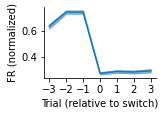

In [29]:
from matplotlib.ticker import MaxNLocator
fig,ax=plt.subplots(figsize=(2,1.3))
toplot=peri_sw_fr_all.loc[(-1,slice(None),slice(None),0,slice(None)),:]
# diff=toplot[5]-toplot[4]
# print(scipy.stats.wilcoxon(diff.dropna()))
fig,ax=ph.mean_error_plot(toplot,fig=fig,ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.despine()
ax.set_ylabel('FR (normalized)')
ax.set_xlabel('Trial (relative to switch)')

# figfn = 'peri_sw_off_fr_peak_vs_trial'
# ph.save_given_name(fig,figfn,figdir=figdir)

In [30]:
df = toplot
res_all = consecutive_wilcoxon_test(df)
res_all

{(-3, -2): WilcoxonResult(statistic=182405.0, pvalue=6.264310955171313e-11),
 (-2, -1): WilcoxonResult(statistic=339975.0, pvalue=0.5031225421036676),
 (-1, 0): WilcoxonResult(statistic=2822.0, pvalue=8.576310366812173e-190),
 (0, 1): WilcoxonResult(statistic=297053.0, pvalue=0.03204757913810585),
 (1, 2): WilcoxonResult(statistic=257544.0, pvalue=0.0866143717882679),
 (2, 3): WilcoxonResult(statistic=231575.0, pvalue=0.4078893620280839)}

(<Figure size 432x288 with 1 Axes>, <Axes: >)

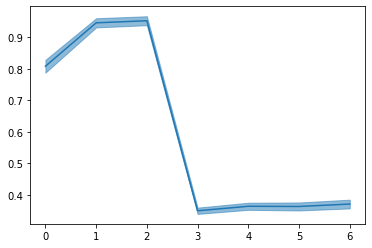

In [82]:
ph.mean_error_plot(peri_sw_fr_all.loc[-1])

(<Figure size 432x288 with 1 Axes>, <Axes: >)

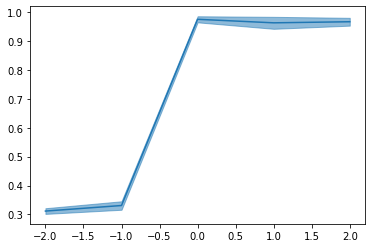

In [60]:
ph.mean_error_plot(peri_sw_fr_all)

In [28]:
np.arange(-2,3)

array([-2, -1,  0,  1,  2])

In [26]:
pf_params_recombined_all.loc[(ani,sess,'peak',ti,tt,uid,field_index),trial_index-2:trial_index+2]

20    0.0
21    NaN
22    0.0
23    5.0
24    NaN
Name: (e14_2m3, e14_2m3_201118, peak, 0, 1.0, 2, 0), dtype: float64

In [23]:
field_index

0

In [18]:
ind

('e14_2m3', 'e14_2m3_201118', 0, 24)

In [20]:
row['trial_index']

22

In [ ]:
pf_params_recombined_all

In [11]:
row = subdb.iloc[0]
data_dir_full = row['data_dir_full']
sess_name=row['sess_name']

ani,sess,ti = row['animal_name.1'],row['sess_name'],0
all_sw_onesess=all_sw_with_metrics_d_all.loc[ani,sess,ti]

/tmp/ipykernel_3127482/3757278894.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_onesess=all_sw_with_metrics_d_all.loc[ani,sess,ti]


In [12]:
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


In [94]:
# one example ratemap
# sub=all_sw_onesess.query('switch==1&pre_mean_fr_all_norm<0.3&uid==150')
sub=all_sw_onesess.query('switch==1&pre_mean_fr_all_norm<0.3')
# row=sub.iloc[2]
row=sub.iloc[3]
sw_id=row.name
tt,uid,field_index,index_within,trial_index=row['trialtype'],row['uid'],row['field_index'],row['index_within'],row['trial_index']

/tmp/ipykernel_3127482/662056429.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


Text(0.5, 1.0, 'e13_26m1_210913\nNeuron 455, Turn 1')

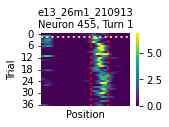

In [95]:
trial_index_to_index_within_df_one=trial_index_to_index_within_df_all[ani,sess].loc[ti]
row=trial_index_to_index_within_df_one.loc[trial_index_to_index_within_df_one.index.get_level_values(1)==trial_index]
tt_plot=row.index[0][0]

frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)

st,ed=all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_index),['start','end']]

### ratemap example
fig,ax=plt.subplots(figsize=(2,4/3))
fig,ax=ph.ratemap_one_raw(frmap_one.T,trial=index_within,field_bound=(st,ed),fig=fig,ax=ax)
ax.set_xticks([])
ax.set_ylabel('Trial')
ax.set_title(f'{sess}\nNeuron {uid}, Turn {int(tt_plot)}')
# figfn = f'ratemap_ex_{sess}_{int(ti)}_{int(tt_plot)}_{int(uid)}_{int(field_index)}_swind{int(sw_id)}'
# ph.save_given_name(fig,figfn,figdir=figdir)

In [96]:

intvl=nap.IntervalSet(start=spk_beh_df['time'].iloc[0],end=spk_beh_df['time'].iloc[-1])


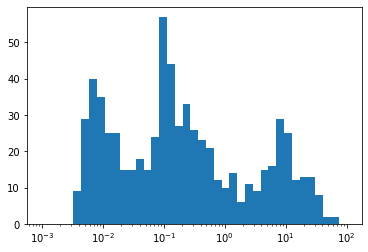

In [97]:
spktrain_one=spike_trains[uid].restrict(intvl)
isi_one=np.diff(spktrain_one.index)
logbin = np.logspace(np.log10(1e-3),np.log10(100),40)
plt.hist(isi_one,logbin)
plt.xscale('log')

In [98]:
def get_intvl_given_trial_space(spk_beh_df,tr,field_st=None,field_ed=None,ti=0):
    ma_str='task_index==@ti&trial==@tr'
    if field_ed is not None:
        ma_str+='&lin_binned<=@field_ed'
    if field_st is not None:
        ma_str+='&lin_binned>=@field_st'
    time_sel = spk_beh_df.query(ma_str)['time']
    time_st,time_ed=time_sel.iloc[0],time_sel.iloc[-1]
    intvl=nap.IntervalSet(start=time_st,end=time_ed)
    return intvl

In [99]:
f_st,f_ed=all_fields_recombined_all.loc[ani,sess,ti,tt,uid,field_index][['start','end']]

In [100]:
intvl = get_intvl_given_trial_space(spk_beh_df,tr=trial_index,field_st=f_st,field_ed=f_ed)

In [101]:
intvl = get_intvl_given_trial_space(spk_beh_df,tr=trial_index+1,field_st=f_st,field_ed=f_ed)

In [118]:
tr_l=index_within_to_trial_index_df_all[ani,sess].loc[ti,tt].values

In [120]:
tr_l

array([ 0,  2,  4,  5,  7,  9, 11, 13, 15, 17, 19, 21, 22, 24, 26, 28, 30,
       32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64,
       66, 67, 69])

In [121]:
tr_l=tr_l[tr_l>trial_index]

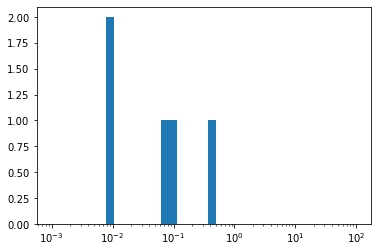

In [103]:
intvl = get_intvl_given_trial_space(spk_beh_df,tr=trial_index,field_st=f_st,field_ed=f_ed)
isi_formation_trial=np.diff(spktrain_one.restrict(intvl).index)
logbin = np.logspace(np.log10(1e-3),np.log10(100),40)
plt.hist(isi_formation_trial,logbin)
plt.xscale('log')

In [104]:
isi_formation_trial

array([0.10153333, 0.0106    , 0.0767    , 0.01056667, 0.4492    ])

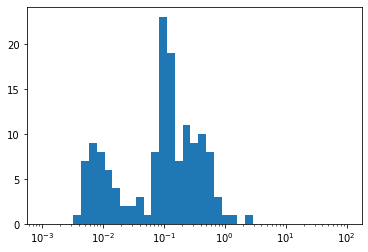

In [122]:
isi_another_trial_l = []
for tr in tr_l:
    intvl = get_intvl_given_trial_space(spk_beh_df,tr=tr,field_st=f_st,field_ed=f_ed)
    isi_another_trial=np.diff(spktrain_one.restrict(intvl).index)
    isi_another_trial_l.append(isi_another_trial)
isi_another_trial_l = np.concatenate(isi_another_trial_l)
logbin = np.logspace(np.log10(1e-3),np.log10(100),40)
plt.hist(isi_another_trial_l,logbin)
plt.xscale('log')